In [1]:
from libs.edgelistParser import edgelistParser, list2matrix
from libs.page_rank import approximateSimrank, localPageRank
from libs.plotNetwork import plotNetworkClusters
import numpy as np
from matplotlib import pyplot as plt
import heapq as hq
import networkx as nx

In [2]:
# load the Facebook dataset
A, N, D = edgelistParser("datasets/facebook/0.edges", "raw_list")

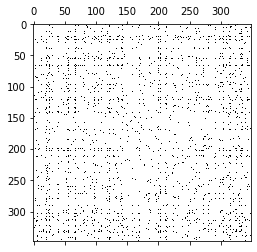

In [3]:
# convert the edge list to a dense matrix
A_mat = list2matrix(A)
plt.figure()
plt.spy(A_mat)
plt.show()

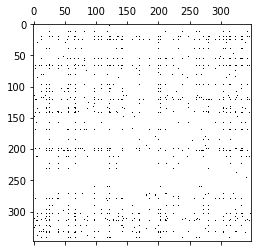

In [4]:
# generate the L matrix
L = localPageRank(A, c=0.85, use_only_neighbours=True)
plt.figure()
plt.spy(L)
plt.show()

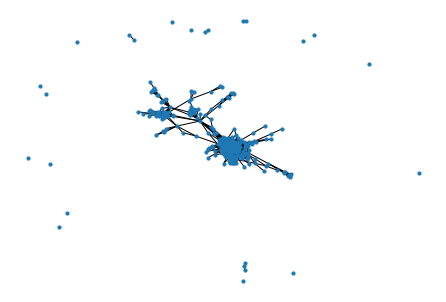

In [105]:
# test the network plot
g = nx.Graph(A_mat)
plt.figure()
nx.draw_spring(g, node_size=10)
plt.show()

In [109]:
# the function computes the network clustering
def cluster(L_norm, centroids, alpha, A):  
    # initialize the output vector with the clusters
    clusters = - np.ones(L.shape[0])
    
    # initialize the heap queues related to the clusters
    queues = []
    
    # insert centroids in the queues, e.g. (expansions, (node, rank))
    for i in range(centroids.size):
        queue = []
        hq.heappush(queue, (0, (centroids[i], 1)))
        queues.append(queue)
        
        # set the centroid cluster
        clusters[centroids[i]] = centroids[i]
    
    # iterate until all the nodes are assigned to the clusters   
    exit_ext = False
    while not exit_ext:
        #
        cumulative_length = 0
        for queue in queues:
            # assign the new expansions
            for i, node in enumerate(queue):
                # ensure at least one expansion per node
                expansions = max(1, np.round(alpha*node[1][1])) # TODO: eventually change the round function
                
                # modify the queue element with the new expansions
                queue[i] = (
                    - expansions,
                    (node[1][0], node[1][1])
                )
            
            # restore the queue
            hq.heapify(queue)
            
            #print(queue)
        
            # expand the cluster boundary toward the high ranked nodes
            exit_int = False
            while (not exit_int) and len(queue)>0: # TODO: check correctness
                # pop a node that should be expanded 
                node = hq.heappop(queue)
                #print("popped")
                
                # check the termination condition
                expansions_opp = node[0]
                if expansions_opp==0:
                    # no more nodes to expand
                    exit_int = True
                else:
                    #print("else")
                    # reduce the remained number of expansions
                    expansions_opp += 1
                    
                    # TODO: exploit the edgelist to enhance efficiency and ensure correctness
                    # expand the neighbourhood and assign the new expansions
                    #print("where", np.where(L[node[1][0],:]>0)[0])
                    for neighbour in np.where(L[node[1][0],:]>0)[0]:
                        #print(neighbour)
                        # assign the node to the cluster
                        if clusters[neighbour]<0:
                            #print("assigned")
                            clusters[neighbour] = clusters[node[1][0]]
                            
                            # add the node to the queue
                            rank = L[node[1][0],neighbour]
                            hq.heappush(
                                queue,
                                (
                                    np.round(expansions_opp*rank), # TODO: eventually change the round function
                                    (neighbour, rank)
                                )
                            )
                            
            # TODO: check
            cumulative_length += len(queue) 
        
        exit_ext = cumulative_length==0
    
        # test plot
        plotNetworkClusters(A, clusters.astype(int), 5, draw_edges=False)
        
    # return the vector with the clusters
    return clusters

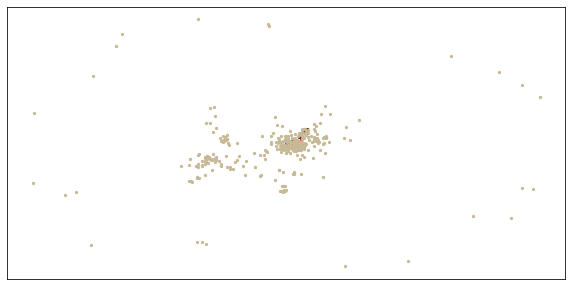

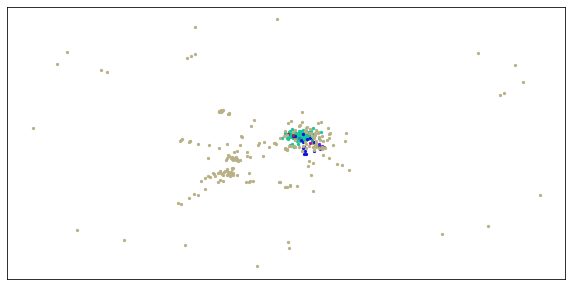

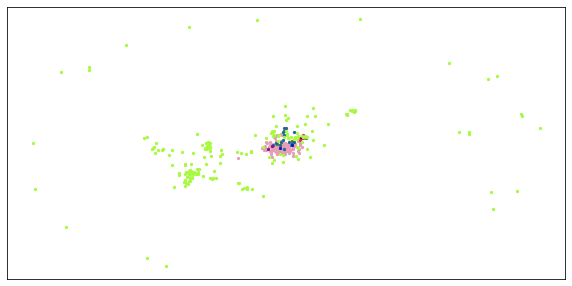

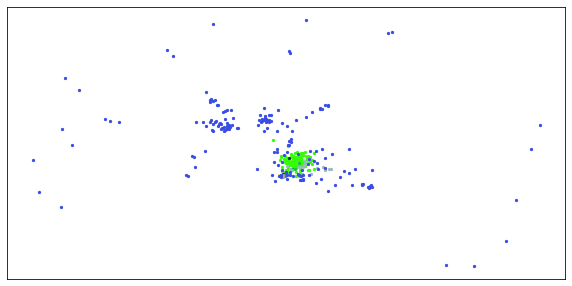

[ -1. 148.  -1. 134.  -1. 134.  -1.   7.  -1. 134. 134.  -1.  -1. 148.
  -1.  -1. 134.  -1.  -1.  -1.  -1. 134. 134.  -1. 180. 134. 134. 134.
  -1. 134. 134. 134.  -1.  -1.  -1.  -1.  -1.  -1.  -1. 134. 134.  -1.
  -1.  -1.  -1. 134.  -1.  -1. 299.  -1. 134. 134.  -1. 134.  -1. 134.
 134.  -1.  -1.  59. 134.  -1. 134.  -1. 148. 134. 134. 134.  -1. 134.
  -1.  -1. 134. 331.  -1. 134.  -1. 134.  -1. 134.  -1.  -1.  59.  -1.
 134. 134.  -1. 134.  88.  -1.  -1.  -1.  -1.  -1.  -1.  -1. 134.  -1.
 134.  -1.  -1. 101.  -1. 134. 134. 148.  -1.  -1.  -1. 134.  -1.  -1.
  -1. 134.  -1.  -1.  -1. 134. 134. 148.  -1. 134. 134. 134.  -1.  -1.
  -1. 134. 134.  -1. 134.  -1. 134. 134. 134.  -1. 134.  -1.  -1.  -1.
  -1. 134. 134.  -1.  -1.  -1. 148.  -1. 148.  -1. 148.  -1.  -1.  -1.
  -1.  -1. 134.  -1. 134. 134.  -1. 134.  -1. 148.  -1. 134.  -1.  -1.
 134. 134. 134. 148. 134.  -1.  -1.  -1. 134.  -1. 148.  -1. 180.  -1.
  -1.  -1.  -1. 148.  88.  -1. 134.  -1.  -1.  -1.  -1.  -1. 180.  -1.
 180. 

In [110]:
# normalize the rows of L
#L_norm = L/np.sum(L, 1)
#L_norm[np.logical_not(np.isfinite(L_norm))] = 0

# test the clustering algorithm
print(cluster(A_mat, np.array([59, 134, 101, 88, 180, 148, 299, 7, 331, 302]), 5, A_mat))

In [100]:
print(np.argsort(np.sum(A_mat, 1)))

[  0  74  37 287  18  43  15 215  12  11 292 210 114 209 335 205 183  33
  34  35 244 241  42  52 233 234  70  47 198 255 216 316  90 153 154 256
 286 160 305 145 282 279 138 267 207  97 112  61  76 155  71 191 164  81
 179 157 182 107 301 336 228 247 321 240 253 294 293 270 288 289  58 125
 124 120 327 307 174 166 262 220  49 206 190 202 201  27 110  46 264 235
 193 192 245 283 250 152 147 163 269 117 219 340 229 173  32  95  77 102
  44   6  86  63 296 126 129 131  51 237 263 300 151 347 311 317 208  64
  83 189 338 167 243  60  54 221  91 162  89 217 259 171 106 260 333 319
  93   8 344 337  68 195 100 328  96 139 218  78  38  16 273 230 306 181
  73 275  69 278  10   4 295   2 309 225 146 135  50  22 318 268 168 140
  36 177 222 298 150 165 341 156 143  45 121  65  79 178  99  29 310  28
  87  17   5  84 108 314 196 111 176 246 149 251 290 226  75  85 274 105
 159 258  39  57  14  20 227 144  66 284 330  24  19 132 281 127 130 137
 187 345 103 197 214 254   3  55  30 175  23   1 11

In [92]:
print(np.sort(np.sum(A_mat, 1)))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  7.  7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  9.
  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.
 13. 14. 14. 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 16. 16. 16. 16. 16. 16. 16. 16. 16